In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import tensorflow as tf

In [3]:
train_dir = "/home/chirag/medical_classification_project/Data/train"
test_dir = "/home/chirag/medical_classification_project/Data/test"
val_dir = "/home/chirag/medical_classification_project/Data/val"

print("Train: ",os.listdir(train_dir))  
print("Test: ",os.listdir(test_dir))  
print("Validation: ",os.listdir(val_dir))  

Train:  ['PNEUMONIA', 'NORMAL']
Test:  ['PNEUMONIA', 'NORMAL']
Validation:  ['PNEUMONIA', 'NORMAL']


Loading data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size=(150,150)
batch_size=25
traingen=ImageDataGenerator(
    rescale=1/255.,
    rotation_range=50,
    brightness_range=[0.2,1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.)

In [13]:
traindata = traingen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/balanced_train',  # New balanced directory
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
    
)

testdata = testgen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/test',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

valdata = valgen.flow_from_directory(
    '/home/chirag/medical_classification_project/Data/val',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)


Found 2600 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [15]:
#loading the mobilenetv2 model without top layer i.e fully cnnected layer
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(150,150,3))
base_model.trainable=False

/tmp/ipykernel_7784/761865436.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(150,150,3))


In [16]:
from tensorflow.keras.regularizers import l2
model=models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128,activation='relu',kernel_regularizer=l2(0.2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32,activation='relu',kernel_regularizer=l2(0.2)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))



In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,113 (9.25 MB)

 Trainable params: 168,129 (656.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Reduce learning rate when validation loss is plateauing
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)


early_stop=EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1,#verbose displays when call back take actions
    mode='min')#for monitor we want minimum value

history=model.fit(traindata,
                  validation_data=valdata,
                  epochs=50,
                  callbacks=[early_stop,lr_scheduler])

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.8627 - loss: 0.7074 - val_accuracy: 0.8750 - val_loss: 0.6197 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.8608 - loss: 0.6579 - val_accuracy: 0.8750 - val_loss: 0.5860 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.8742 - loss: 0.6002 - val_accuracy: 0.8125 - val_loss: 0.5855 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.8799 - loss: 0.5722 - val_accuracy: 0.9375 - val_loss: 0.5485 - learning_rate: 1.0000e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.8847 - loss: 0.5547 - val_accuracy: 1.0000 - val_loss: 0.4972 - learning_rate: 1.0000e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.8886 - loss: 0.5295 - val_accuracy: 1.0000 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 20

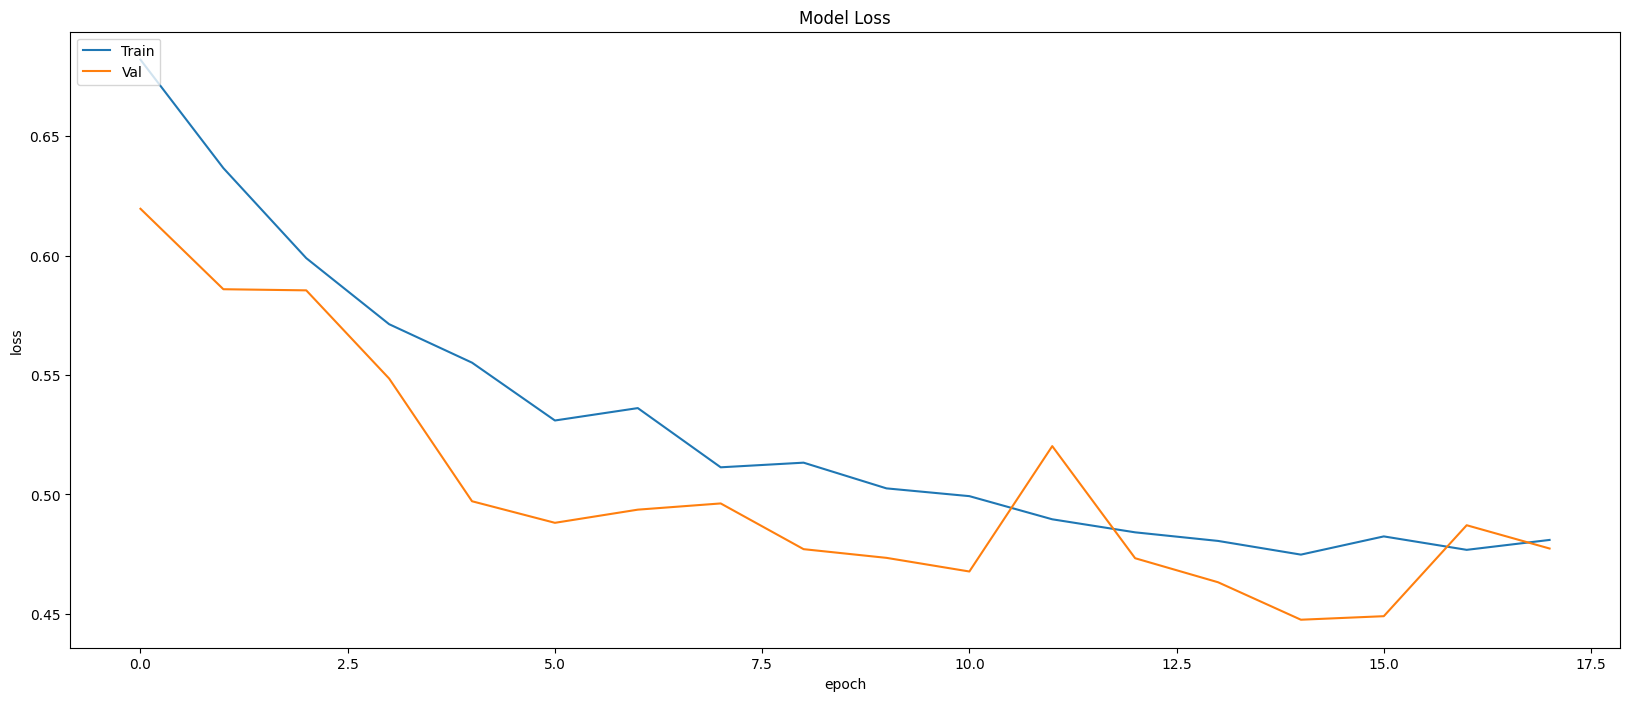

In [21]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

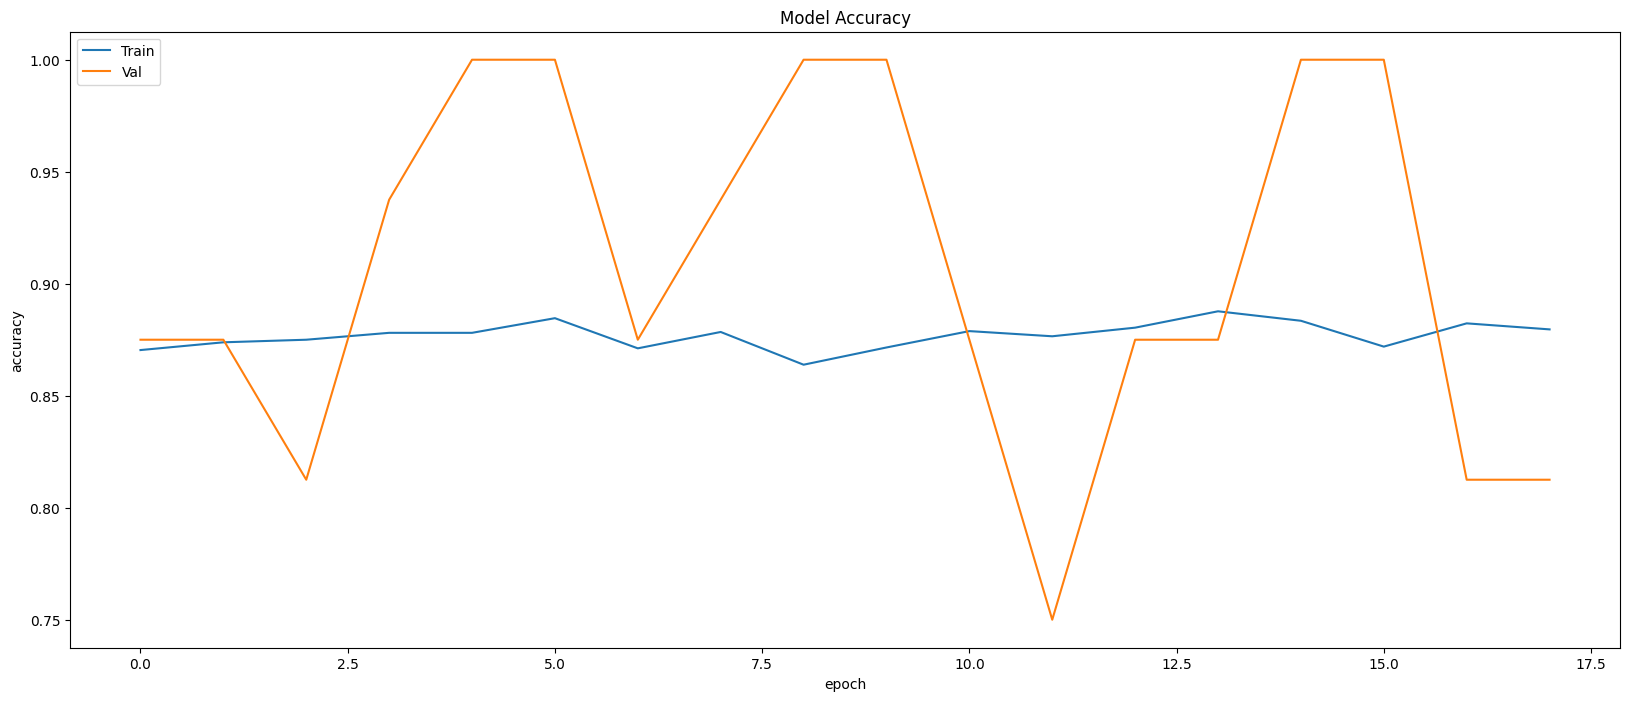

In [22]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(testdata)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8923 - loss: 0.4875

2025-02-19 16:29:06.413644: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1186', 16 bytes spill stores, 16 bytes spill loads

2025-02-19 16:29:06.877989: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1186_0', 344 bytes spill stores, 520 bytes spill loads

2025-02-19 16:29:06.881639: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1186', 104 bytes spill stores, 104 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.8870 - loss: 0.4932
Test Loss: 0.5378127694129944
Test Accuracy: 0.8445512652397156


# Generate and Evaluate Confusion Matrix

In binary classification tasks (e.g., pneumonia detection), a confusion matrix is a great way to understand how well your model is distinguishing between classes. It shows:

    True Positives (TP): Correctly predicted pneumonia cases.
    True Negatives (TN): Correctly predicted non-pneumonia (normal) cases.
    False Positives (FP): Normal cases incorrectly classified as pneumonia.
    False Negatives (FN): Pneumonia cases incorrectly classified as normal.

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step


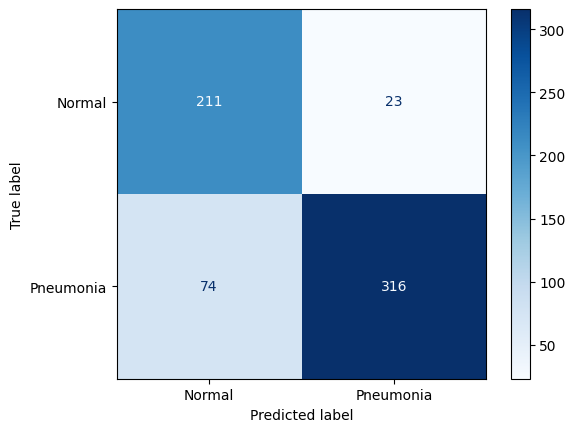

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from the test generator
true_labels = testdata.classes  # True class labels

# Get model predictions
predictions = model.predict(testdata)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Precision,  Recall, and F1-Score

Accuracy alone can be misleading, especially when dealing with imbalanced datasets. Precision, Recall, and the F1-score are more informative metrics:

    Precision: How many of the predicted pneumonia cases were actually pneumonia (True Positives / (True Positives + False Positives)).
    Recall: How many of the actual pneumonia cases were correctly identified (True Positives / (True Positives + False Negatives)).
    F1-Score: The harmonic mean of precision and recall, which balances both metrics.

In [29]:
from sklearn.metrics import classification_report
print('classification report: ')
print(classification_report(true_labels,predicted_labels))

classification report: 
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       234
           1       0.93      0.81      0.87       390

    accuracy                           0.84       624
   macro avg       0.84      0.86      0.84       624
weighted avg       0.86      0.84      0.85       624



# ROC Curve

In [31]:
# Get predicted probabilities for the positive class (Pneumonia)
y_pred_prob = model.predict(testdata)

if y_pred_prob.shape[1] > 1:  
    y_pred_prob = y_pred_prob[:, 1]  # Take the probability for class 1 (Pneumonia)
else:
    y_pred_prob = y_pred_prob.flatten()  # If binary, the array may already be 1D


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


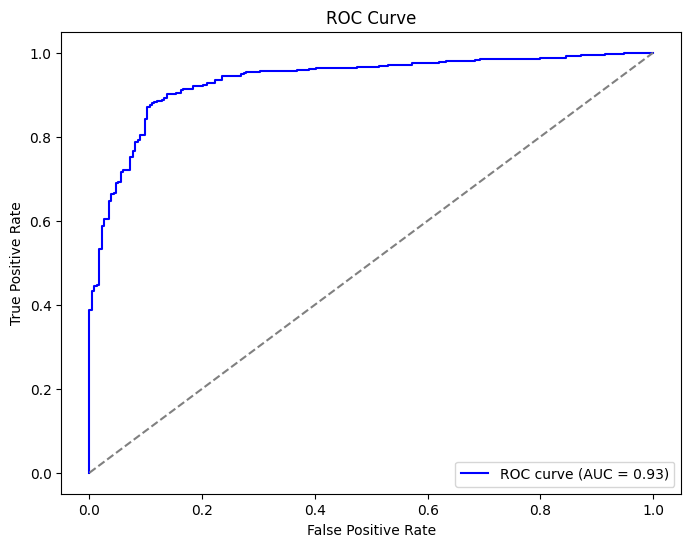

In [33]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

With an AUC of 0.93 we can say that the model is performly very good

In [34]:
model.save('model_MobileNetV2_NonTrainable.keras')

 We will not try to implemet this my making few layers of MobileNetV2 Trainable see how it responds

In [43]:
#loading the mobilenetv2 model without top layer i.e fully cnnected layer
base_model_trainable=MobileNetV2(weights='imagenet',include_top=False,input_shape=(150,150,3))
# Freeze all layers of the base model
for layer in base_model_trainable.layers:
    layer.trainable = False

# Unfreeze the last 4 layers of MobileNetV2
for layer in base_model_trainable.layers[-4:]:
    layer.trainable = True

/tmp/ipykernel_7784/2798991150.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_trainable=MobileNetV2(weights='imagenet',include_top=False,input_shape=(150,150,3))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
model2=Sequential()

model2.add(base_model_trainable)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128,activation='relu',kernel_regularizer=l2(0.2)))
model2.add(Dropout(0.5))
model2.add(Dense(32,activation='relu',kernel_regularizer=l2(0.02)))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))

In [45]:
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,113 (9.25 MB)

 Trainable params: 580,929 (2.22 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [49]:
model2.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [50]:
early_stop2=EarlyStopping(monitor='val_loss',patience=3,
                          mode='auto',verbose=1,restore_best_weights=True)

lr_scheduler2=ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,patience=5,verbose=1)

history2=model2.fit(traindata,validation_data=valdata,
           epochs=50,
           callbacks=[early_stop2,lr_scheduler2])

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.8320 - loss: 9.7214 - val_accuracy: 0.8125 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.9032 - loss: 0.6130 - val_accuracy: 0.5625 - val_loss: 1.5532 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.8880 - loss: 0.4978 - val_accuracy: 0.8125 - val_loss: 0.5072 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.9095 - loss: 0.3829 - val_accuracy: 0.8125 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9156 - loss: 0.3693 - val_accuracy: 0.8750 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.9060 - loss: 0.3595 - val_accuracy: 0.8125 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.9

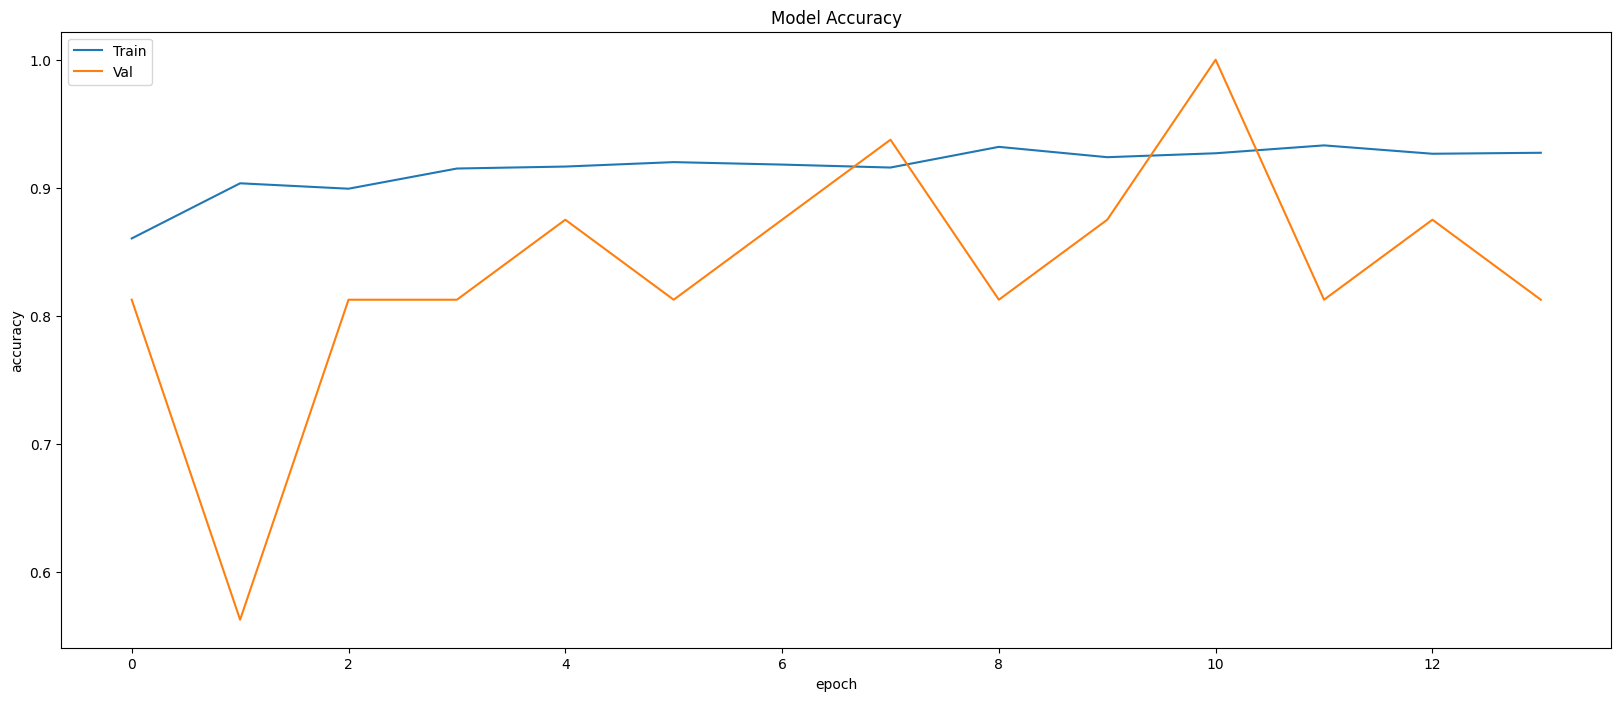

In [51]:
plt.figure(figsize=(20,8))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

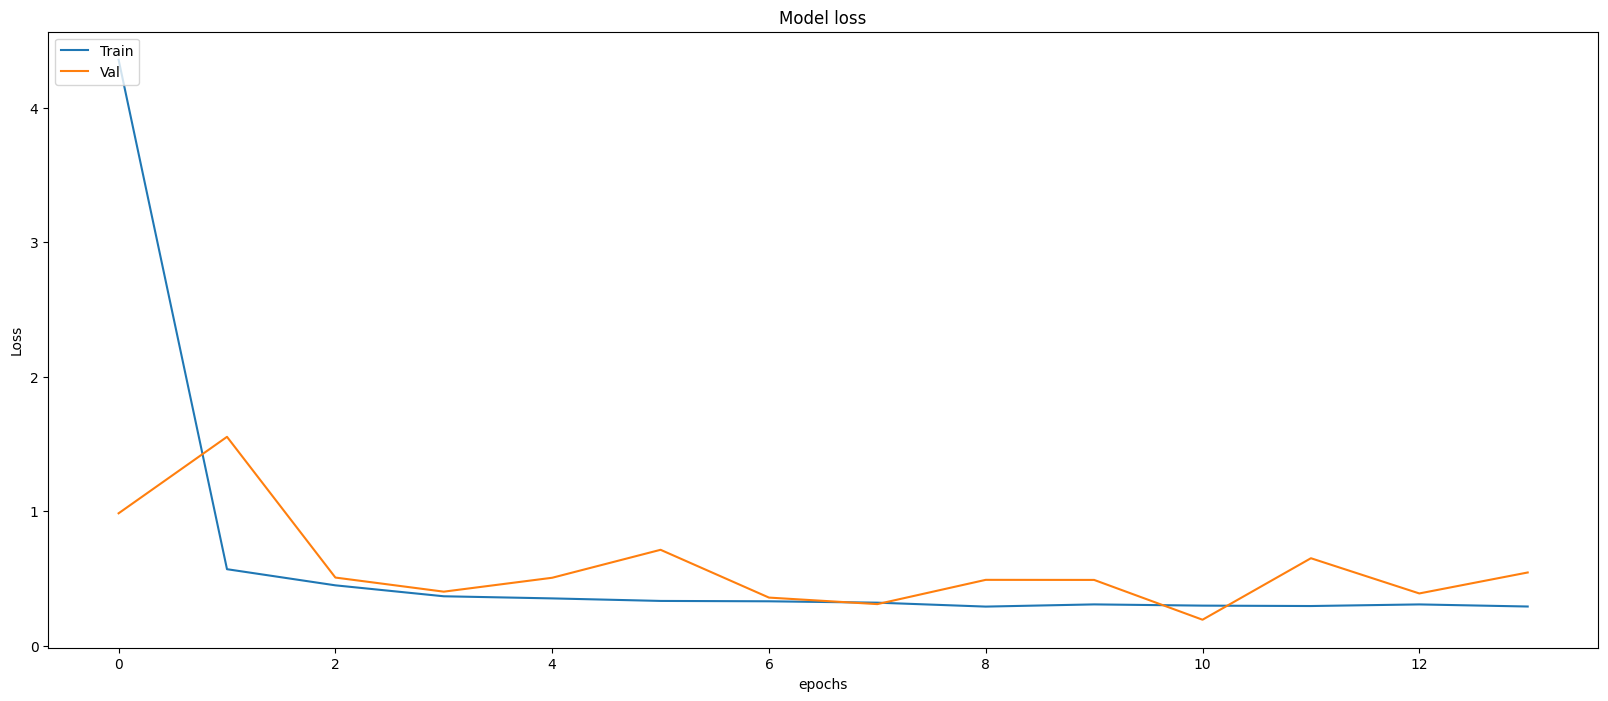

In [52]:
plt.figure(figsize=(20,8))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [59]:
test_loss, test_accuracy = model2.evaluate(testdata)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8551 - loss: 0.5329
Test Loss: 0.44021353125572205
Test Accuracy: 0.8910256624221802


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


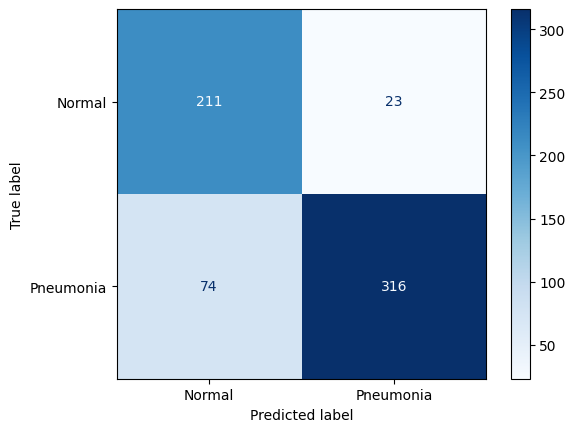

In [60]:
#confusion matrix
true_labels=testdata.classes

prediction=model.predict(testdata)
predicted_labels=(prediction>0.5).astype(int).flatten()

conf_matrix=confusion_matrix(true_labels,predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
from sklearn.metrics import classification_report
print('classification report: ')
print(classification_report(true_labels,predicted_labels))

classification report: 
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       234
           1       0.93      0.81      0.87       390

    accuracy                           0.84       624
   macro avg       0.84      0.86      0.84       624
weighted avg       0.86      0.84      0.85       624



In [63]:
# Get predicted probabilities for the positive class (Pneumonia)
y_pred_prob = model2.predict(testdata)

if y_pred_prob.shape[1] > 1:  
    y_pred_prob = y_pred_prob[:, 1]  # Take the probability for class 1 (Pneumonia)
else:
    y_pred_prob = y_pred_prob.flatten()  # If binary, the array may already be 1D


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step


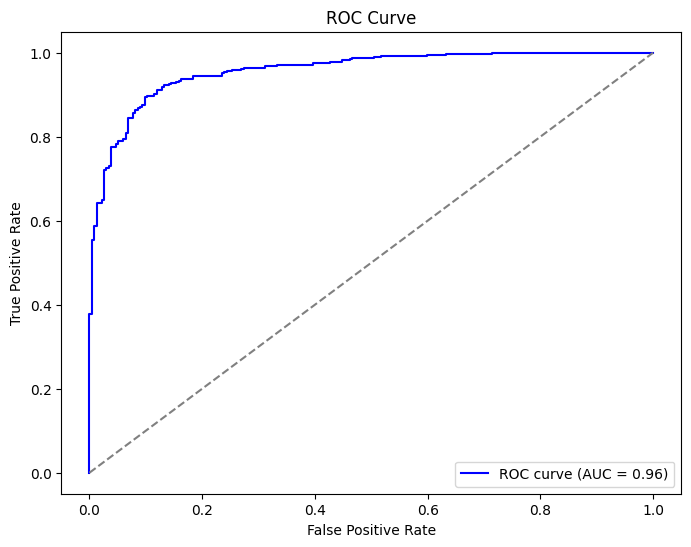

In [64]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [65]:
model2.save('model_MobileNetV2_Trainable.keras')